# Application of the standard pipeline to ASD data.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
from pathlib import Path
import os

## Data loading

In [2]:
from pathlib import Path

path = Path('../data/asd/raw')
freqs = np.linspace(4, 12, 41)

info = pd.read_csv(path / 'path_file.csv')
info['fn'] = info['fn'].str.replace('и' + chr(774), 'й') # For some reason, filenames encode й as 2 unicode characters
info = info.groupby("fn").filter(lambda x: len(x) == 1)
typical = np.where(info['target'] == 'typical')[0]
asd = np.where(info['target'] == 'asd')[0]

eegs = {i: mne.io.read_raw_fif(path / fn, verbose=False) for i, fn in info['fn'].items()}
ch_names = eegs[0].ch_names

assert np.all([eegs[i].info['sfreq'] == sfreq for i, sfreq in info['sfreq'].items()])
info

fn   target dataset_name  sfreq  \
0      sedrykyn_sasha_7_og_concat_19.raw.fif      asd          asd    125   
1       roma gritchin _5_fon_open_19.raw.fif      asd          asd    125   
2                 boy5_asd_og_new_19.raw.fif      asd          asd    125   
3    viflyancev_4_asd_fon__concat_19.raw.fif      asd          asd    125   
4         andrey_matveev3_asd_new_19.raw.fif      asd          asd    125   
..                                       ...      ...          ...    ...   
330            artem_sarkis_6_fon_19.raw.fif  typical      typical    125   
331               gusarova_9_norm_19.raw.fif  typical      typical    125   
332     акулов миша 10 от даши_ог_19.raw.fif  typical      typical    125   
333                      жавнис_3_19.raw.fif  typical      typical    125   
334           никита 7 от даши_ог_19.raw.fif  typical      typical    125   

     age  seconds  
0      7     47.0  
1      5     33.0  
2      5     50.0  
3      4     58.0  
4      3     50.0  
..   ...      ...  
330    6     44.0  
331    9     83.0  
332   10     42.0  
333    3    386.0  
334    7     57.0  

[327 rows x 6 columns]

## Reformating names (Extra)

In [3]:
csv_path = Path('../data/asd/csv')
if not csv_path.exists():
    csv_path.mkdir()

for i, fn in info['fn'].items():
    eegs[i].to_data_frame(index='time').to_csv(csv_path/fn)

info.to_csv(csv_path/'path_file.csv', index=False)

In [ ]:
info

fn   target dataset_name  sfreq  \
0      sedrykyn_sasha_7_og_concat_19.raw.fif      asd          asd    125   
1       roma gritchin _5_fon_open_19.raw.fif      asd          asd    125   
2                 boy5_asd_og_new_19.raw.fif      asd          asd    125   
3    viflyancev_4_asd_fon__concat_19.raw.fif      asd          asd    125   
4         andrey_matveev3_asd_new_19.raw.fif      asd          asd    125   
..                                       ...      ...          ...    ...   
330            artem_sarkis_6_fon_19.raw.fif  typical      typical    125   
331               gusarova_9_norm_19.raw.fif  typical      typical    125   
332     акулов миша 10 от даши_ог_19.raw.fif  typical      typical    125   
333                      жавнис_3_19.raw.fif  typical      typical    125   
334           никита 7 от даши_ог_19.raw.fif  typical      typical    125   

     age  seconds  
0      7     47.0  
1      5     33.0  
2      5     50.0  
3      4     58.0  
4      3     50.0  
..   ...      ...  
330    6     44.0  
331    9     83.0  
332   10     42.0  
333    3    386.0  
334    7     57.0  

[327 rows x 6 columns]

## Application of the pipeline

In [3]:
import sys
sys.path.append('../')

from pipeline.features import get_merged_df
from pipeline import models, validation
from sklearn.metrics import roc_auc_score

In [4]:
features_path = Path('../data/asd/features')
feature_methods = [
    'env-alpha',
    'env-beta',
    'coh-alpha',
    'coh-beta',
    'bands'
]

age_groups = {'2-4': range(2, 5),
              '5-6': range(5, 7),
              '7-9': range(7, 10),
              '10+': range(10, 20)}

In [5]:
data = get_merged_df(features_path / 'all_0_0_30', feature_methods)
features = list(data.columns.difference(['fn', 'target']))
data['target'] = data['target'] == 'asd'
data = data.join(info[['fn', 'age']].set_index('fn'), on='fn')
data

env_alpha_Fp1_Fp2  env_alpha_Fp1_F7  env_alpha_Fp1_F3  env_alpha_Fp1_Fz  \
0             0.891998          0.509431          0.826220          0.696588   
1             0.115062          0.472489          0.487474          0.878222   
2             0.447426          0.695395          0.917096          0.994707   
3             0.569617          0.303238          0.399967          0.364938   
4             0.227313          0.628836          0.573654          0.457972   
..                 ...               ...               ...               ...   
322           0.241978          0.666872          0.528407          0.677278   
323           0.141243          0.884357          0.946885          0.650569   
324           0.608975          0.445951          0.644476          0.631161   
325           0.557102          0.646782          0.627265          0.734367   
326           0.362031          0.723264          0.584031          0.412112   

     env_alpha_Fp1_F4  env_alpha_Fp1_F8  env_alpha_Fp1_T3  env_alpha_Fp1_C3  \
0            0.506631          0.613676          0.450674          0.388555   
1            0.123275          0.111016          0.328021          0.340626   
2            0.165988          0.241781          0.209849         -0.086952   
3           -0.127901          0.071616          0.174688          0.244335   
4           -0.009362          0.058419          0.306366          0.253811   
..                ...               ...               ...               ...   
322          0.342389          0.241669          0.176328          0.201078   
323          0.092479          0.174086          0.649125          0.404404   
324          0.378532          0.282728          0.389884          0.263613   
325          0.395172          0.288729          0.091180          0.061418   
326          0.149928          0.250411          0.249253          0.113289   

     env_alpha_Fp1_Cz  env_alpha_Fp1_C4  ...  bands_beta_Pz  bands_alpha_P4  \
0            0.315504          0.240434  ...       0.101699        0.116350   
1            0.032669          0.131682  ...       0.189171        0.152464   
2            0.022487         -0.017244  ...       0.091215        0.084294   
3            0.034526          0.044588  ...       0.055008        0.080802   
4            0.059236         -0.040549  ...       0.212417        0.117376   
..                ...               ...  ...            ...             ...   
322          0.069925          0.168248  ...       0.123841        0.144923   
323          0.580261          0.043740  ...       0.122492        0.299244   
324          0.268184          0.360216  ...       0.231209        0.128161   
325          0.034771          0.062188  ...       0.055613        0.177089   
326          0.096633         -0.001801  ...       0.158875        0.136810   

     bands_beta_P4  bands_alpha_T6  bands_beta_T6  bands_alpha_O1  \
0         0.092670        0.122020       0.113816        0.110691   
1         0.145222        0.099042       0.244947        0.137443   
2         0.128256        0.093687       0.197270        0.073230   
3         0.080717        0.076018       0.160046        0.071993   
4         0.265736        0.116461       0.696908        0.161141   
..             ...             ...            ...             ...   
322       0.058803        0.139114       0.099993        0.068829   
323       0.137468        0.245692       0.144902        0.207365   
324       0.207269        0.135182       0.359872        0.134419   
325       0.080501        0.129400       0.130751        0.127480   
326       0.150076        0.097199       0.276587        0.118093   

     bands_beta_O1  bands_alpha_O2  bands_beta_O2  age  
0         0.102988        0.113449       0.091439    7  
1         0.206588        0.123850       0.194655    5  
2         0.275141        0.064865       0.146672    5  
3         0.153367        0.076317       0.139539    4  
4         0.582664        0.1642

In [6]:
model = models.LRScaled()

## Nested KFold

In [7]:
selected_features = {}
scores = {}


for ag_name, ag in age_groups.items():
    df = data[data['age'].isin(ag)].copy().reset_index(False)
    method = validation.NestedCrossValidator(df, features, model, p_bar=0, random_state=57)
    selected_features[ag_name], scores[ag_name] = method.get_features()
    print(f"Age group {ag_name}:\n\tn_subjects = {len(df)}\n\t{scores[ag_name].roc_auc = }\n\t{scores[ag_name].acc = }")

Age group 2-4:
	n_subjects = 82
	scores[ag_name].roc_auc = 0.6582582582582582
	scores[ag_name].acc = 0.6219512195121951
Age group 5-6:
	n_subjects = 83
	scores[ag_name].roc_auc = 0.6187943262411347
	scores[ag_name].acc = 0.6265060240963856
Age group 7-9:
	n_subjects = 97
	scores[ag_name].roc_auc = 0.6376500857632934
	scores[ag_name].acc = 0.5463917525773195
Age group 10+:
	n_subjects = 64
	scores[ag_name].roc_auc = 0.4407530454042082
	scores[ag_name].acc = 0.5


### Commonly-selected features

In [19]:
from collections import Counter

counts = {ag: Counter() for ag in age_groups}

for ag_name, s_f in selected_features.items():
    for split in s_f:
        counts[ag_name].update(split)


## Feature visualization

In [11]:
montage = mne.channels.make_standard_montage('standard_1020')

# create Info object to store info
info = mne.io.meas_info.create_info(montage.ch_names, sfreq=256, ch_types="eeg")
# using temporary RawArray to apply mongage to info
mne.io.RawArray(np.zeros((len(montage.ch_names), 1)), info, copy=None).set_montage(montage)

# pick channels
channels_to_use_ = [ch for ch in info.ch_names if ch in ch_names]
info.pick_channels(channels_to_use_);

# get positions
_, pos, _, ch_names, _, _, _ = mne.viz.topomap._prepare_topomap_plot(info, 'eeg');
pos = pd.DataFrame(pos, columns=['x', 'y'], index=ch_names)

Creating RawArray with float64 data, n_channels=94, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


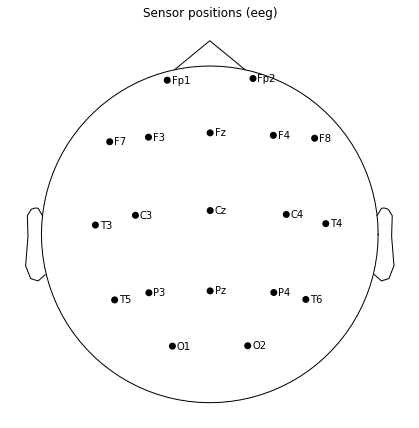

In [22]:
mne.viz.utils.plot_sensors(info, show_names=True, show=False)
plt.tight_layout()
plt.savefig(f'../images/asd/sensors.jpg')

In [12]:
from itertools import product
feature_types = list(map('_'.join, product(('coh', 'env', 'bands'), ('alpha', 'beta'))))

def parse_features(features):
    result = {k: [] for k in feature_types}
    for feature in features:
        split = feature.split('_')
        result['_'.join(split[:2])].append(split[2:])
    return result

def parse_feature_counts(features):
    result = {k: {} for k in feature_types}
    for feature, count in features.items():
        split = feature.split('_')
        result['_'.join(split[:2])][tuple(split[2:])] = count
    return result

In [13]:

def flatten(lst: list[list]) -> list:
    flat = []
    for lst_ in lst:
        flat.extend(lst_)
    return flat

def plot_features_type(channels, ax):
    if not channels:
        return
    dots = pos.loc[flatten(channels)]
    ax.scatter(*dots.values.T, s=300, alpha=0.5, c='orange')
    if len(channels[0]) == 2:
        for pair in channels:
            ax.plot(*pos.loc[pair].values.T, lw=2, c='orange')

def annotate_counts(channels, ax):
    for chans, count in channels.items():
        ax.annotate(count, pos.loc[list(chans)].mean(axis=0))

In [14]:
def plot_features_fold(features, axes):
    for (type_, chans), ax in zip(parse_features(features).items(), axes):
        mne.viz.utils.plot_sensors(info, show_names=False, show=False, axes=ax, title=type_)
        plot_features_type(chans, ax)

def plot_featues_agg(features, axes):
    plot_features_fold(features, axes)
    for channels, ax in zip(parse_feature_counts(features).values(), axes):
        annotate_counts(channels, ax)

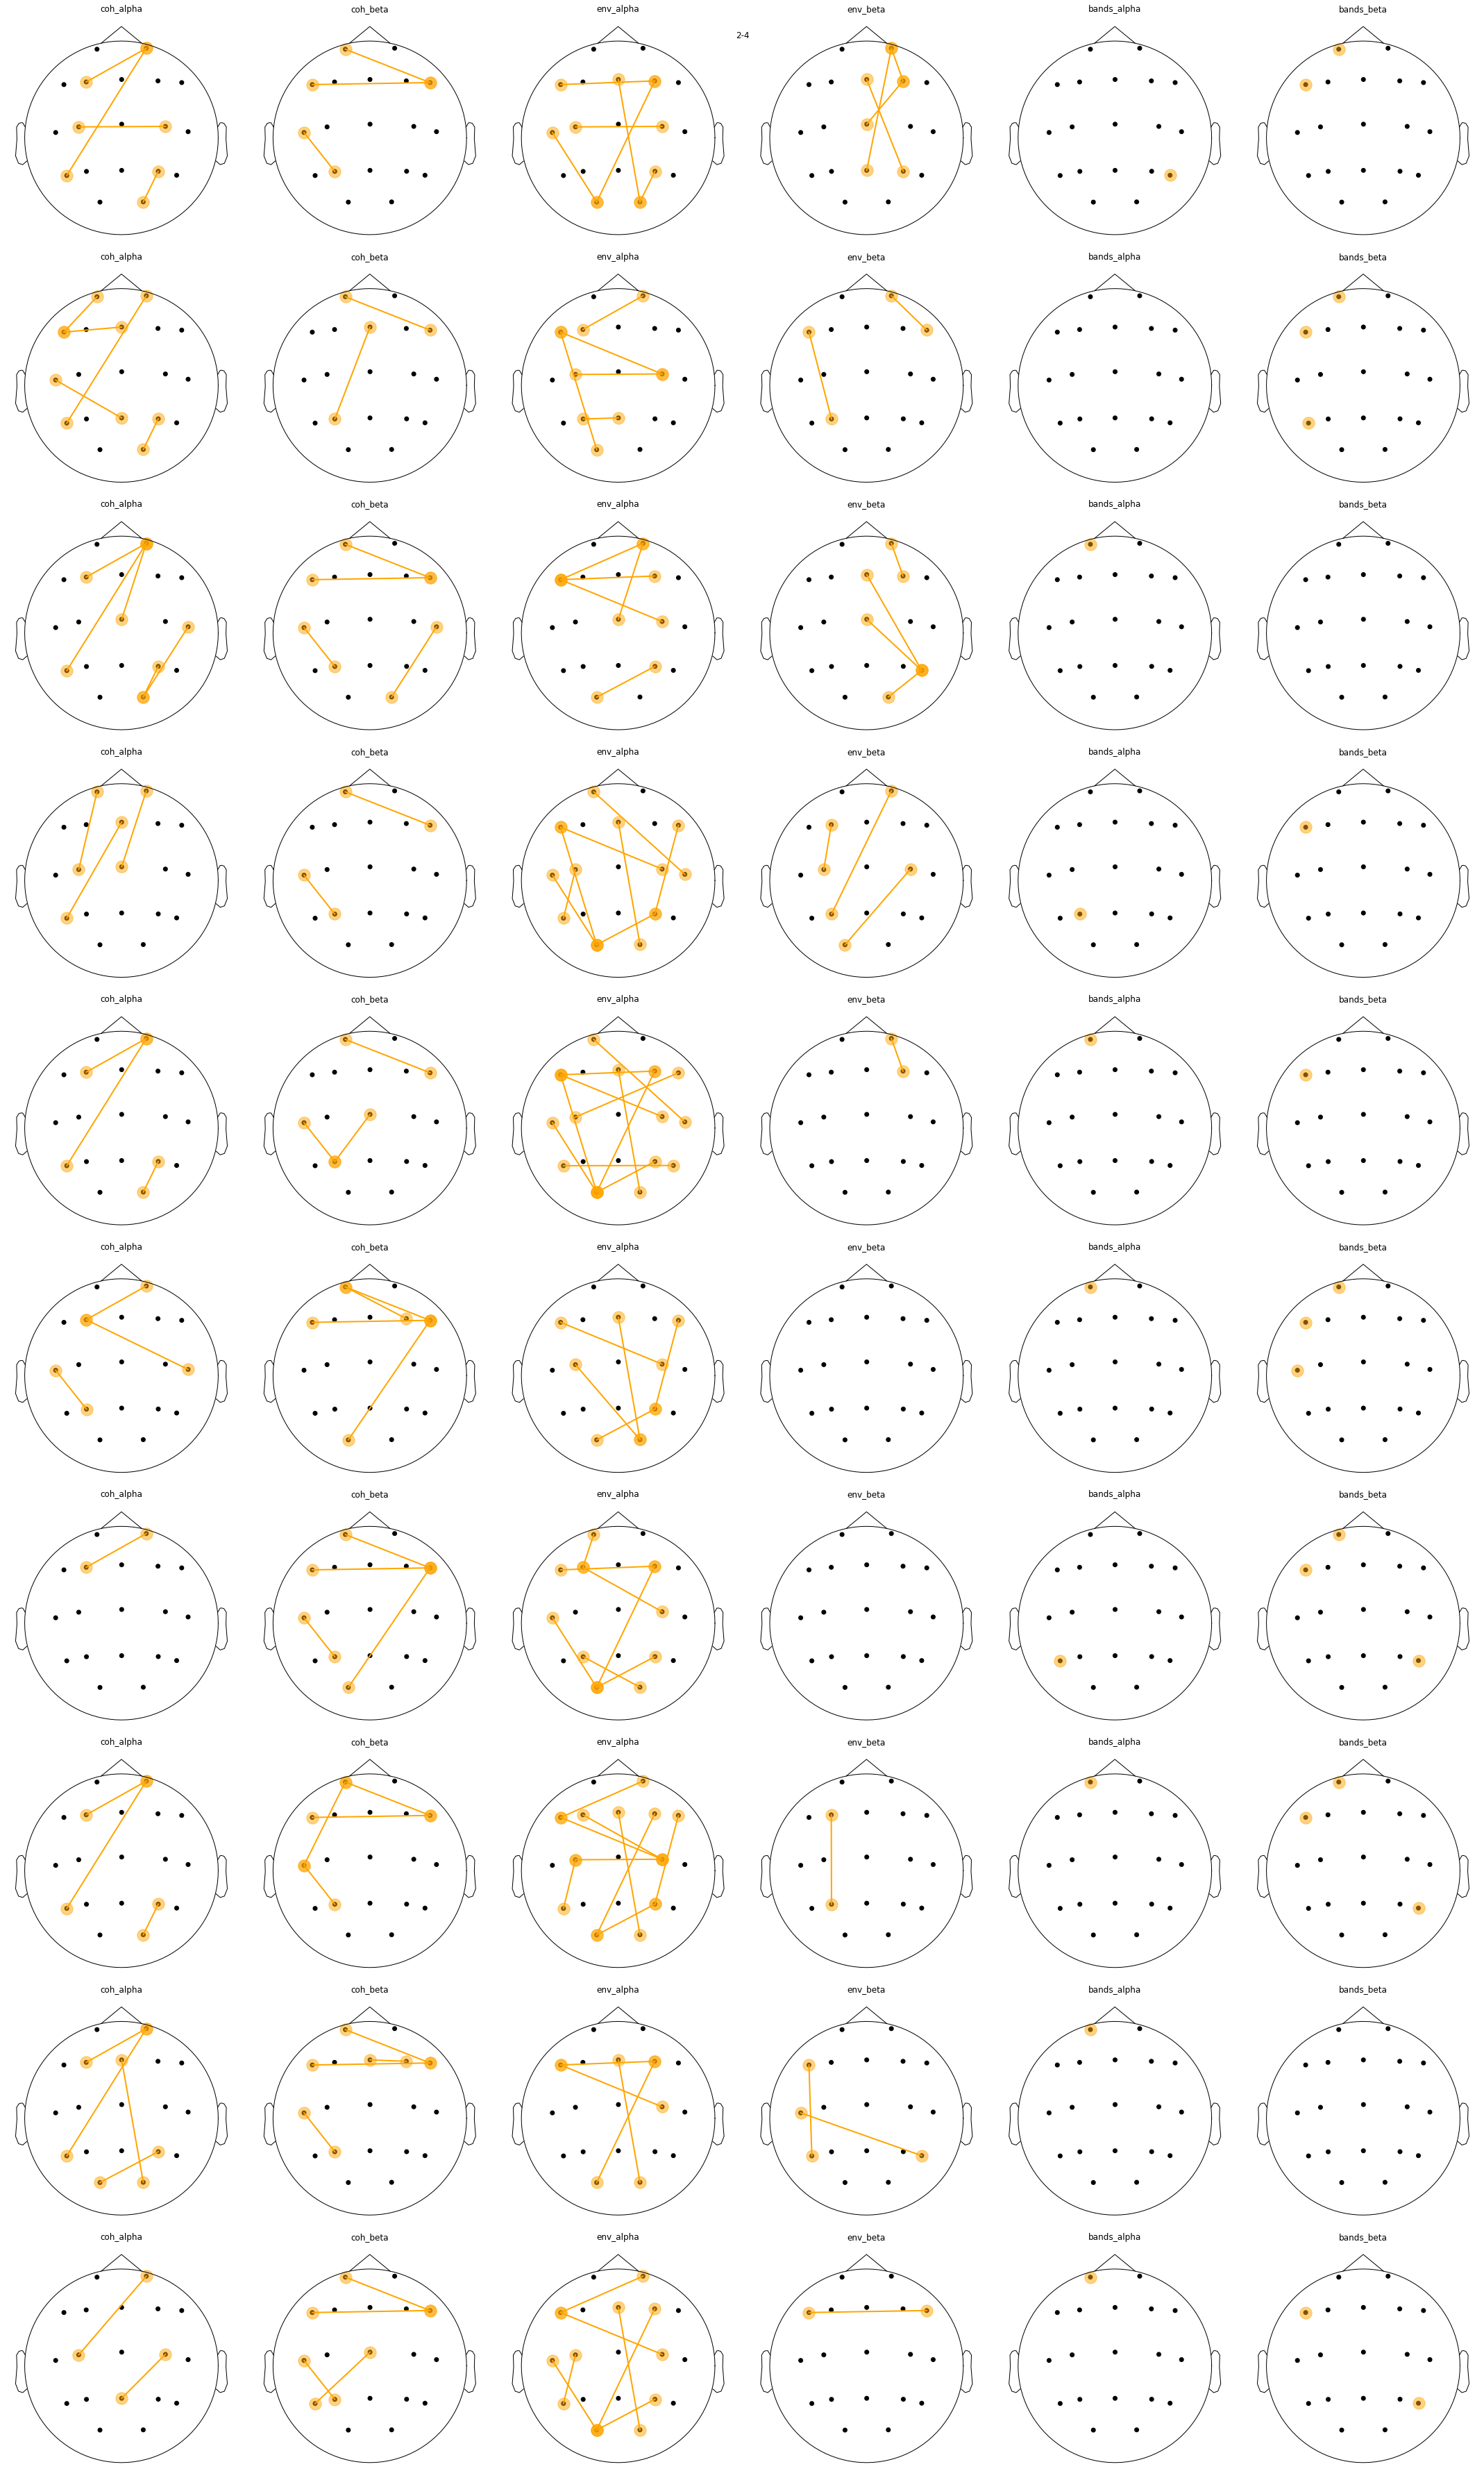

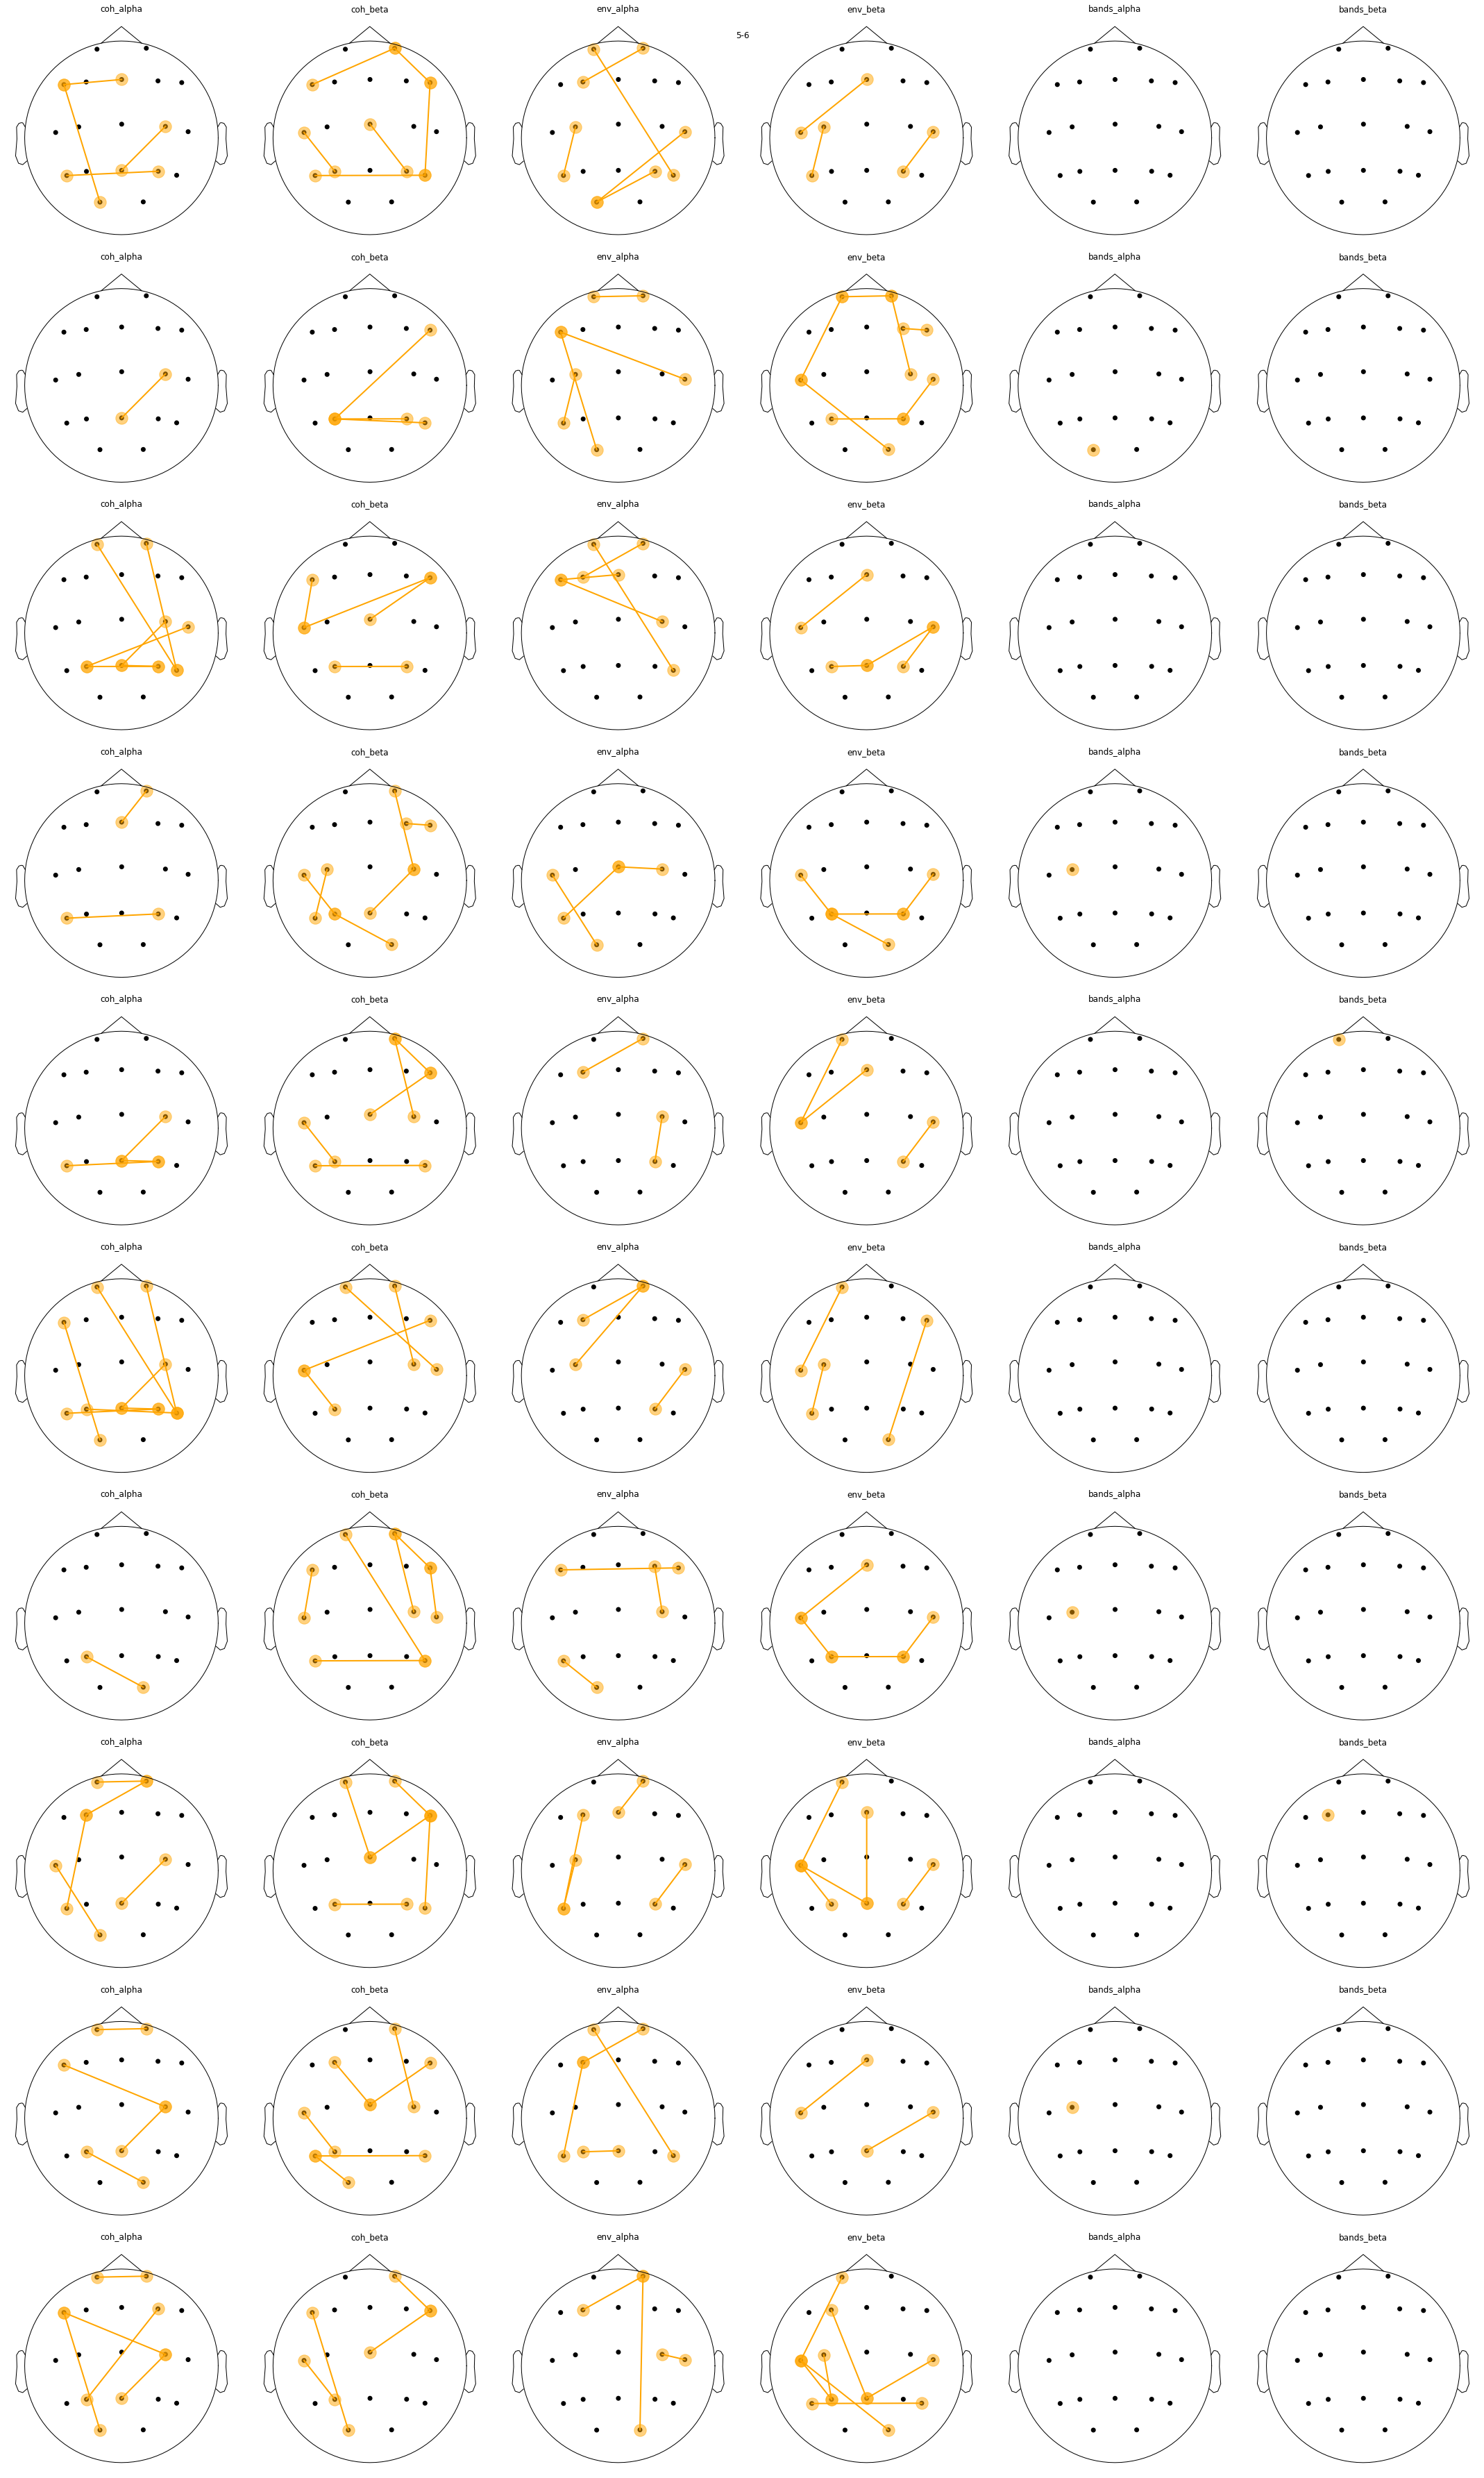

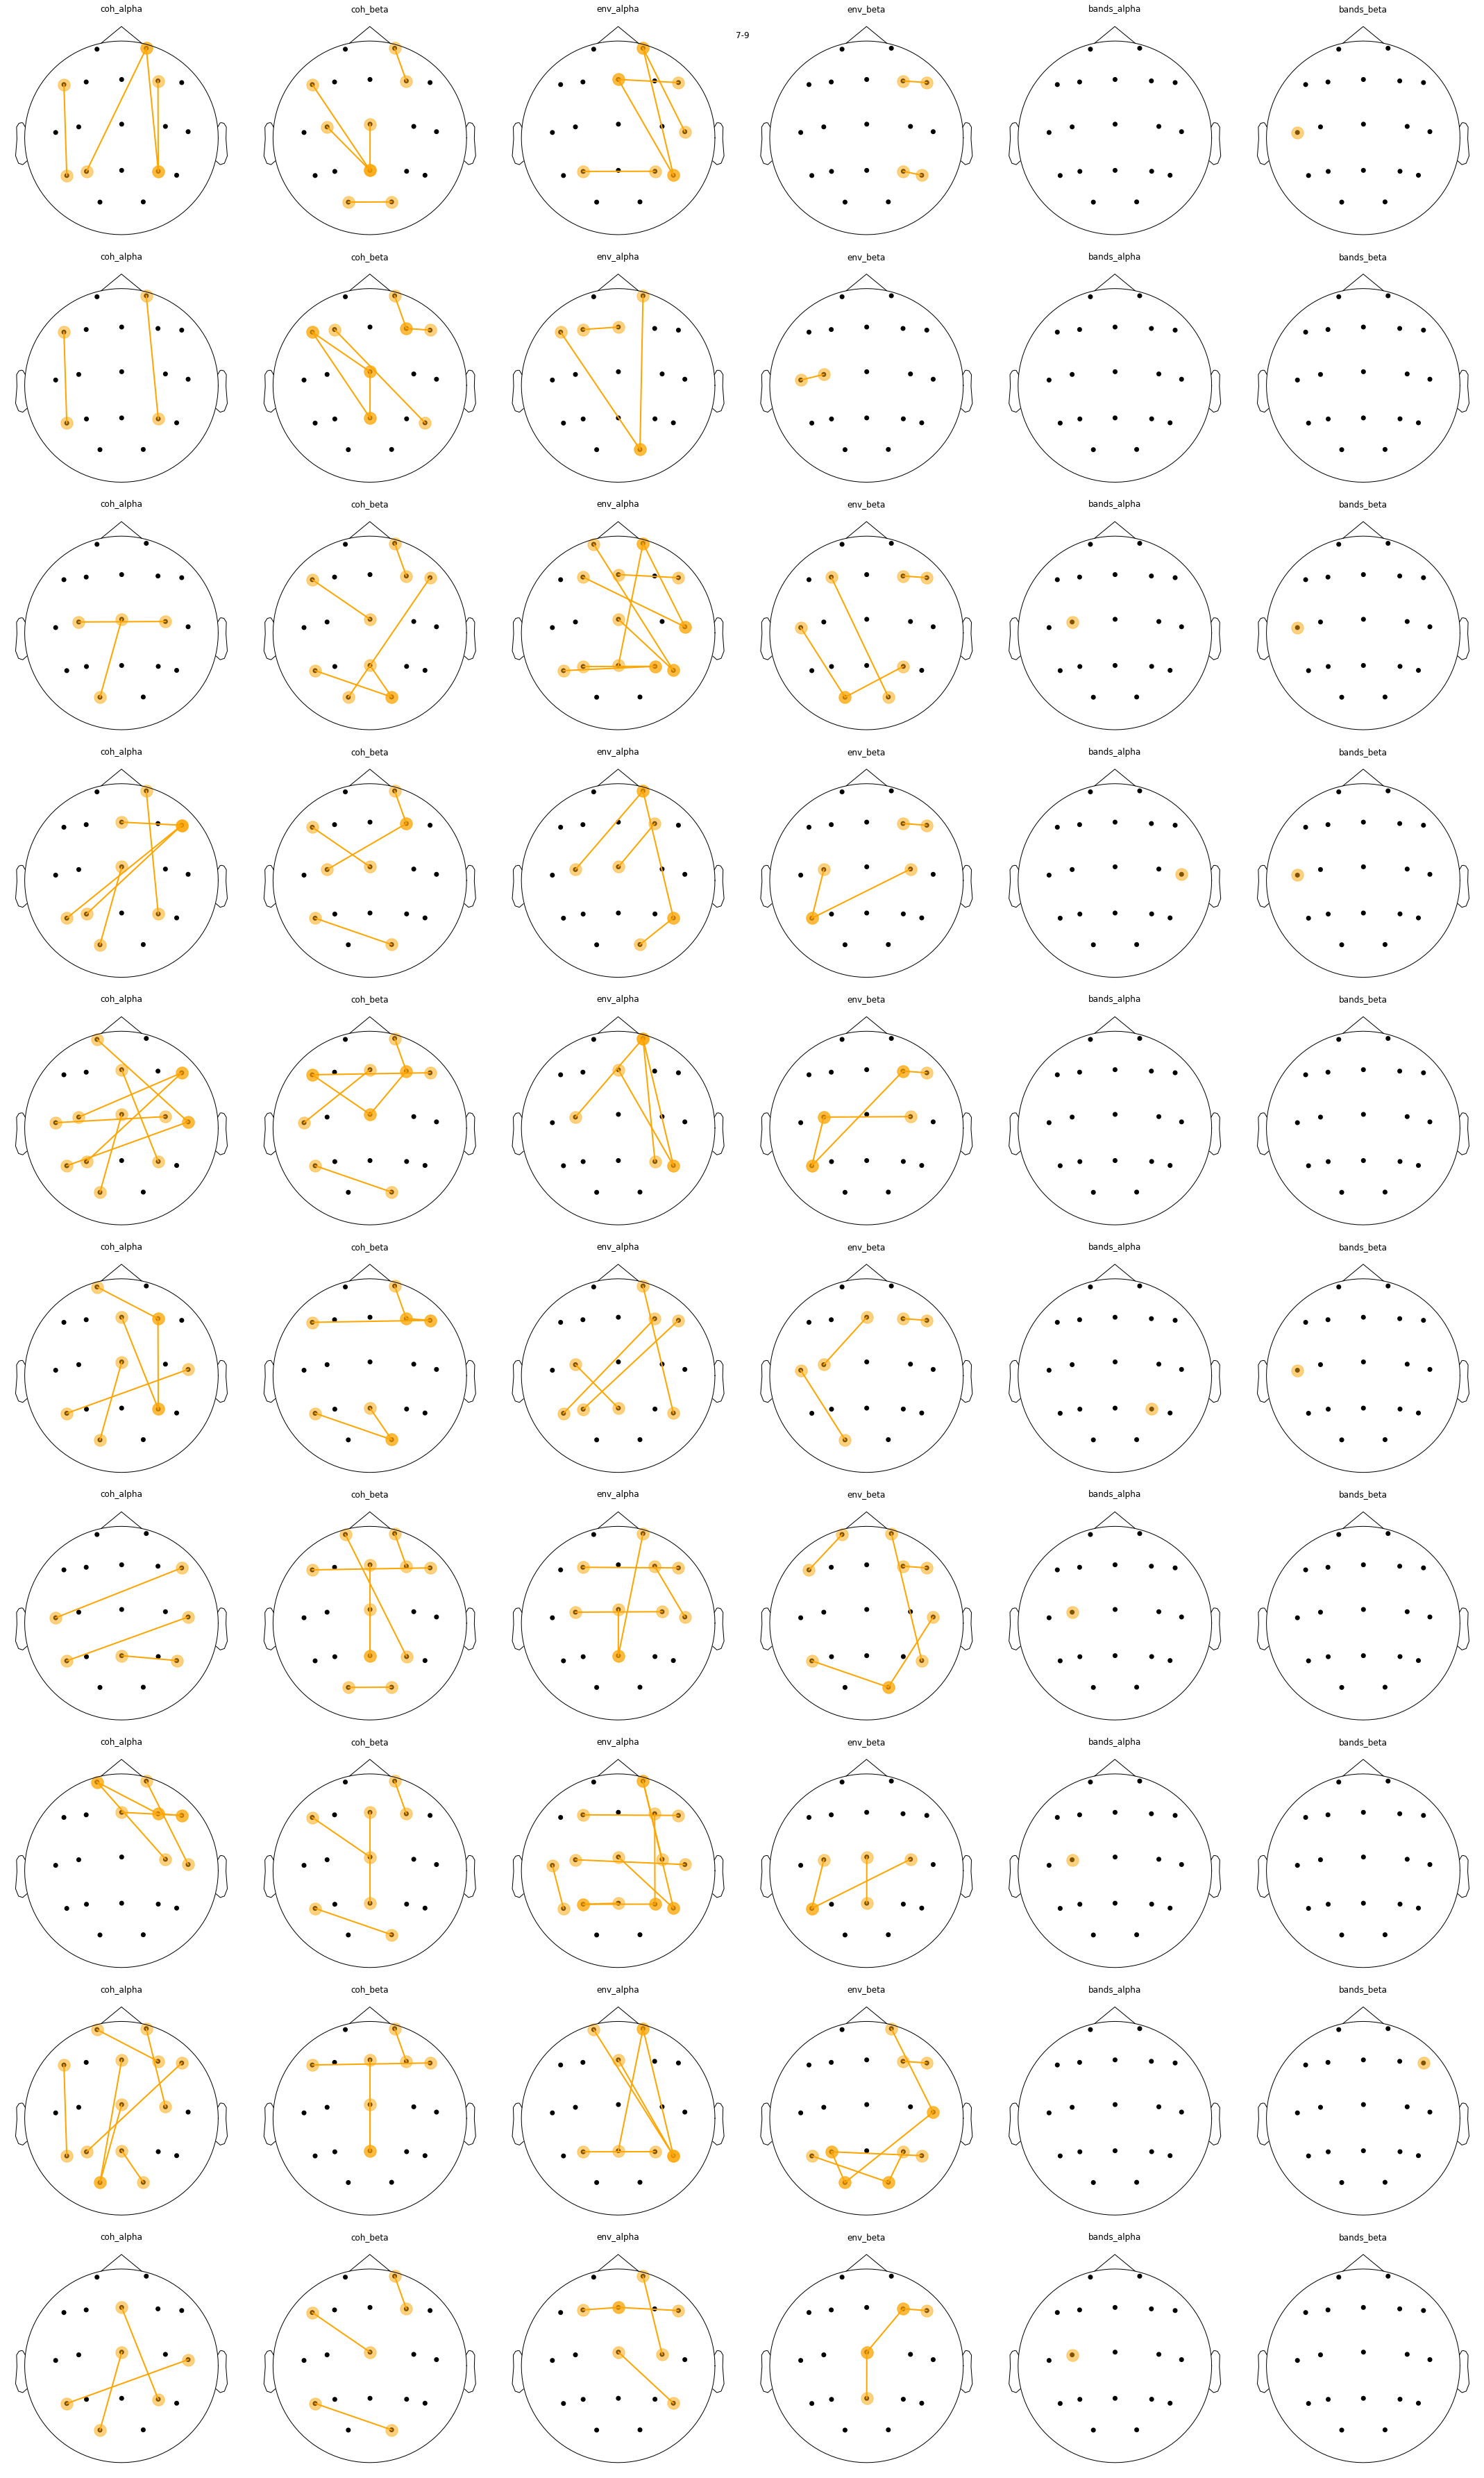

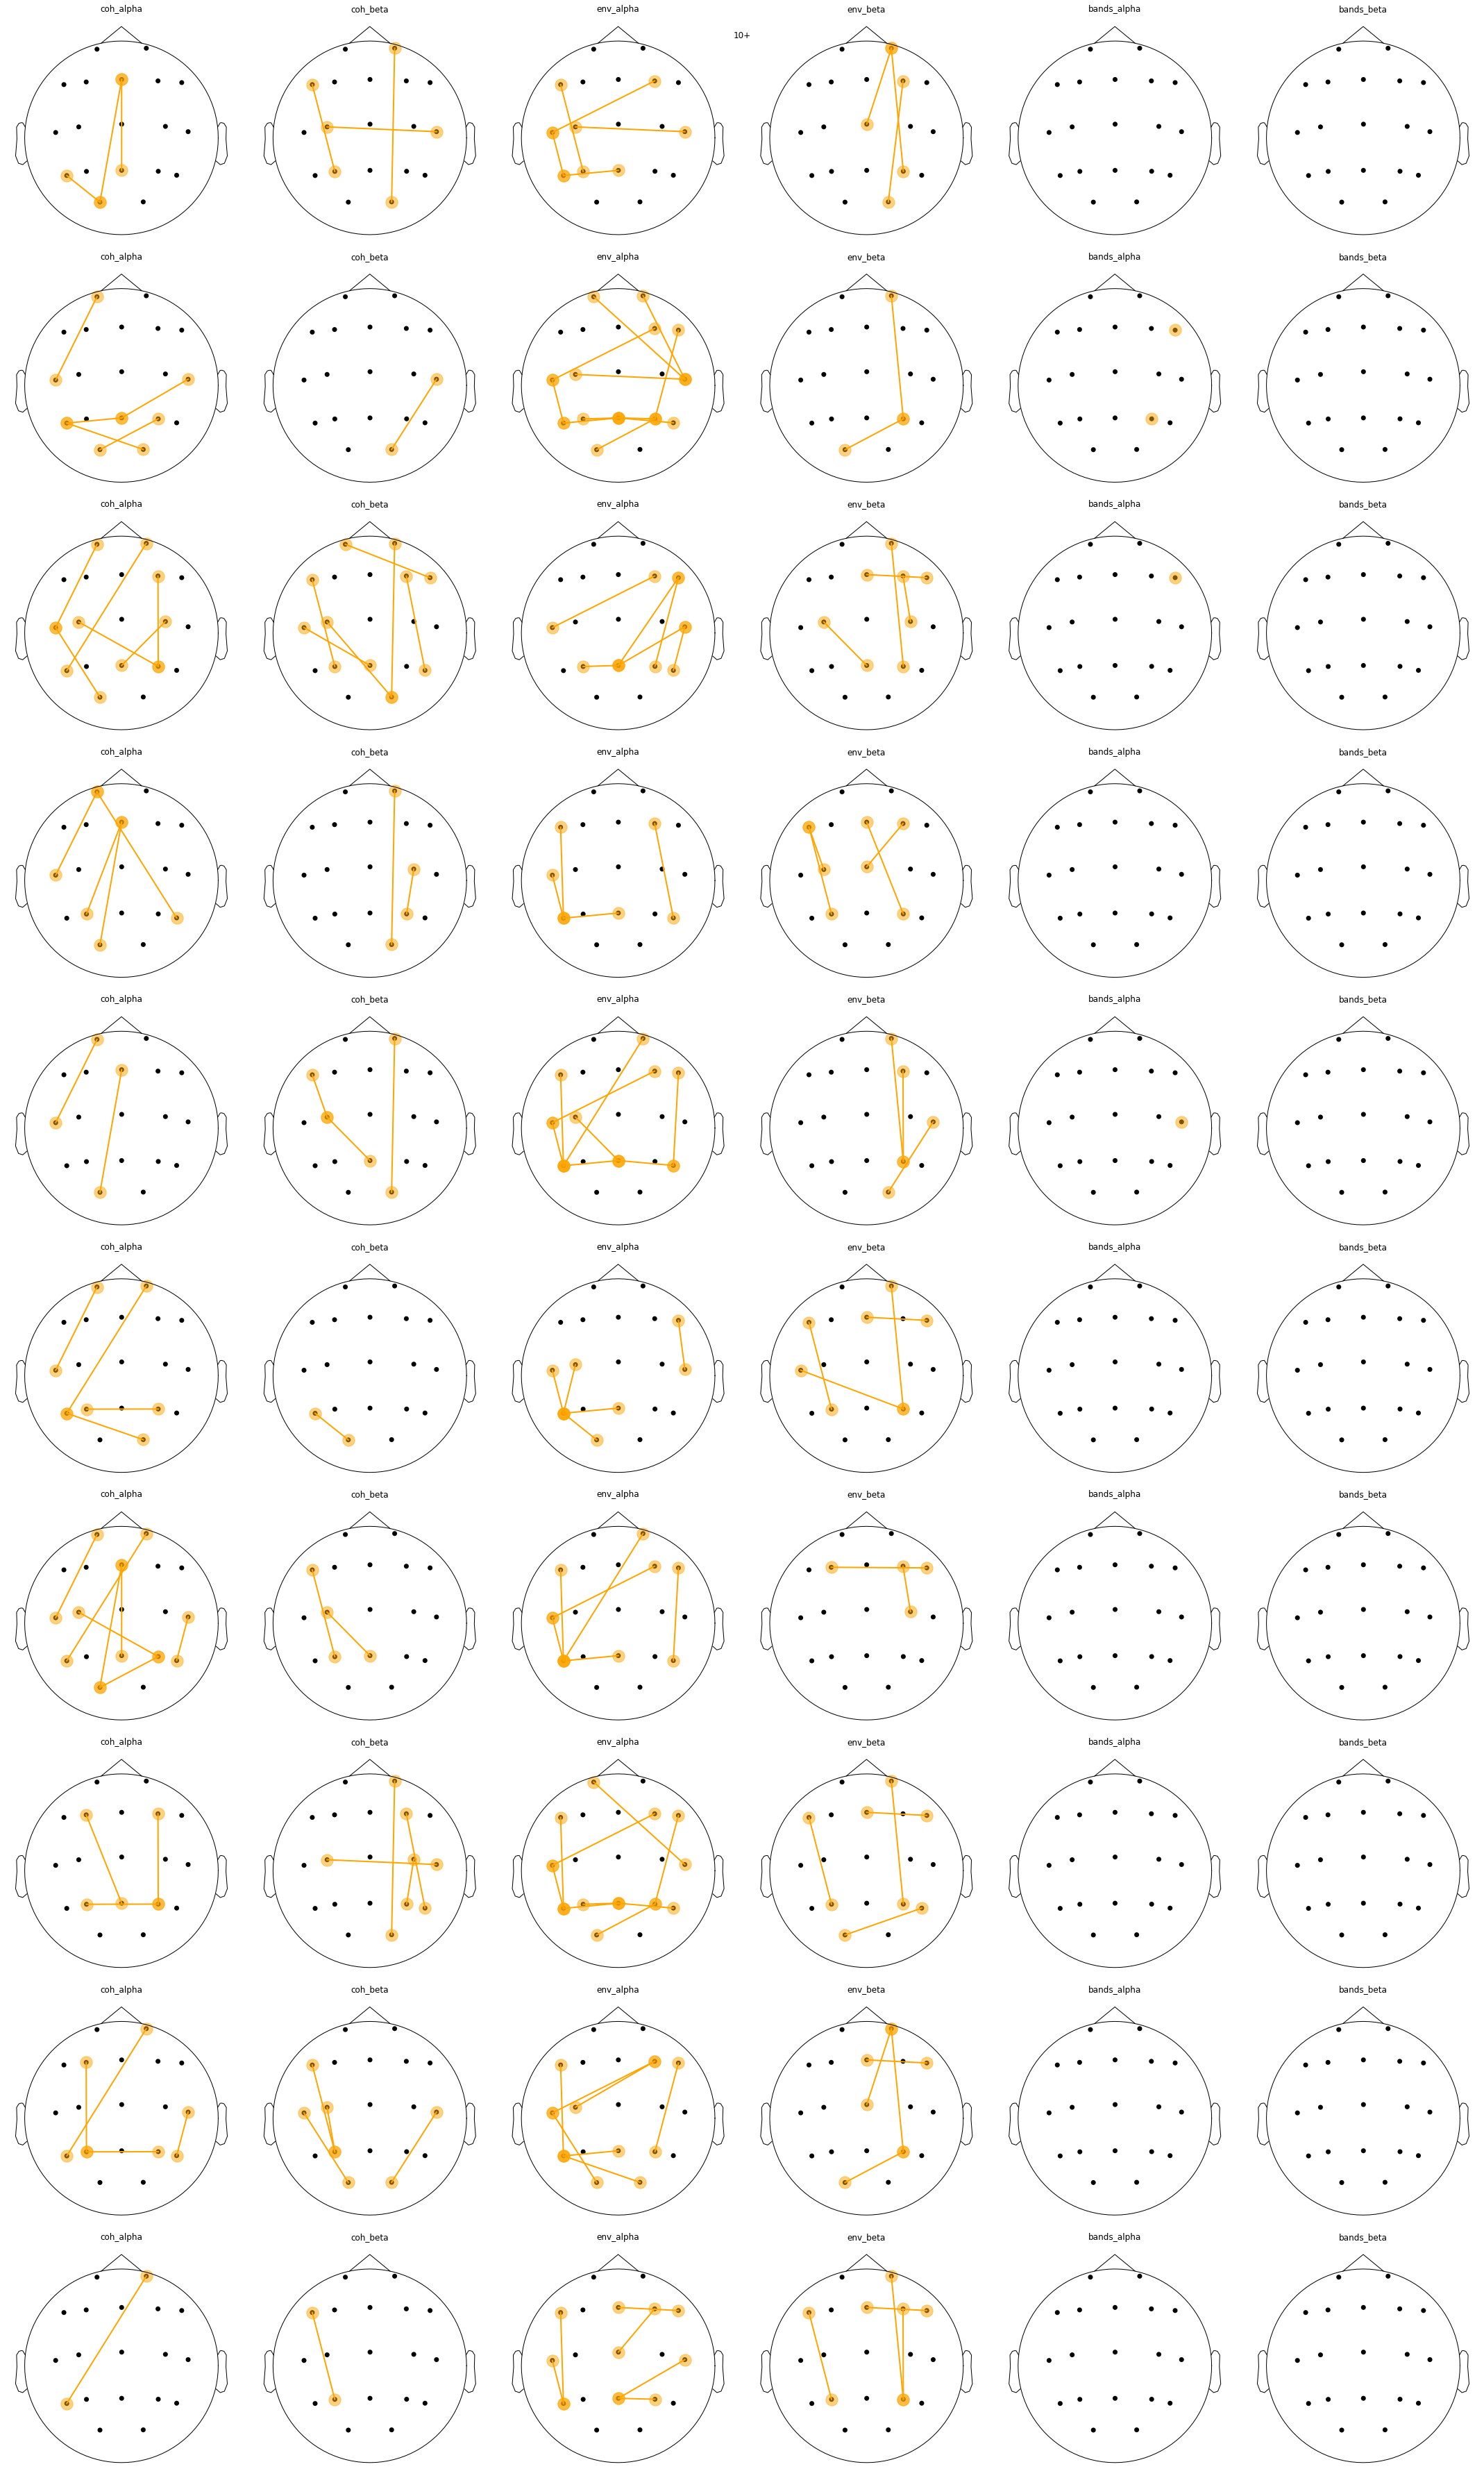

In [26]:
for ag_name, s_f in selected_features.items():
    n_folds, n_cols = len(s_f), 6
    fig, axes = plt.subplots(n_folds, n_cols, figsize=(5 * n_cols, 5 * n_folds))
    plt.subplots_adjust(wspace=0, hspace=0)
    for i, fold in enumerate(s_f):
        plot_features_fold(fold, axes[i])
    fig.suptitle(ag_name)
    plt.tight_layout()
    plt.savefig(f'../images/asd/({ag_name})_folds.jpg')

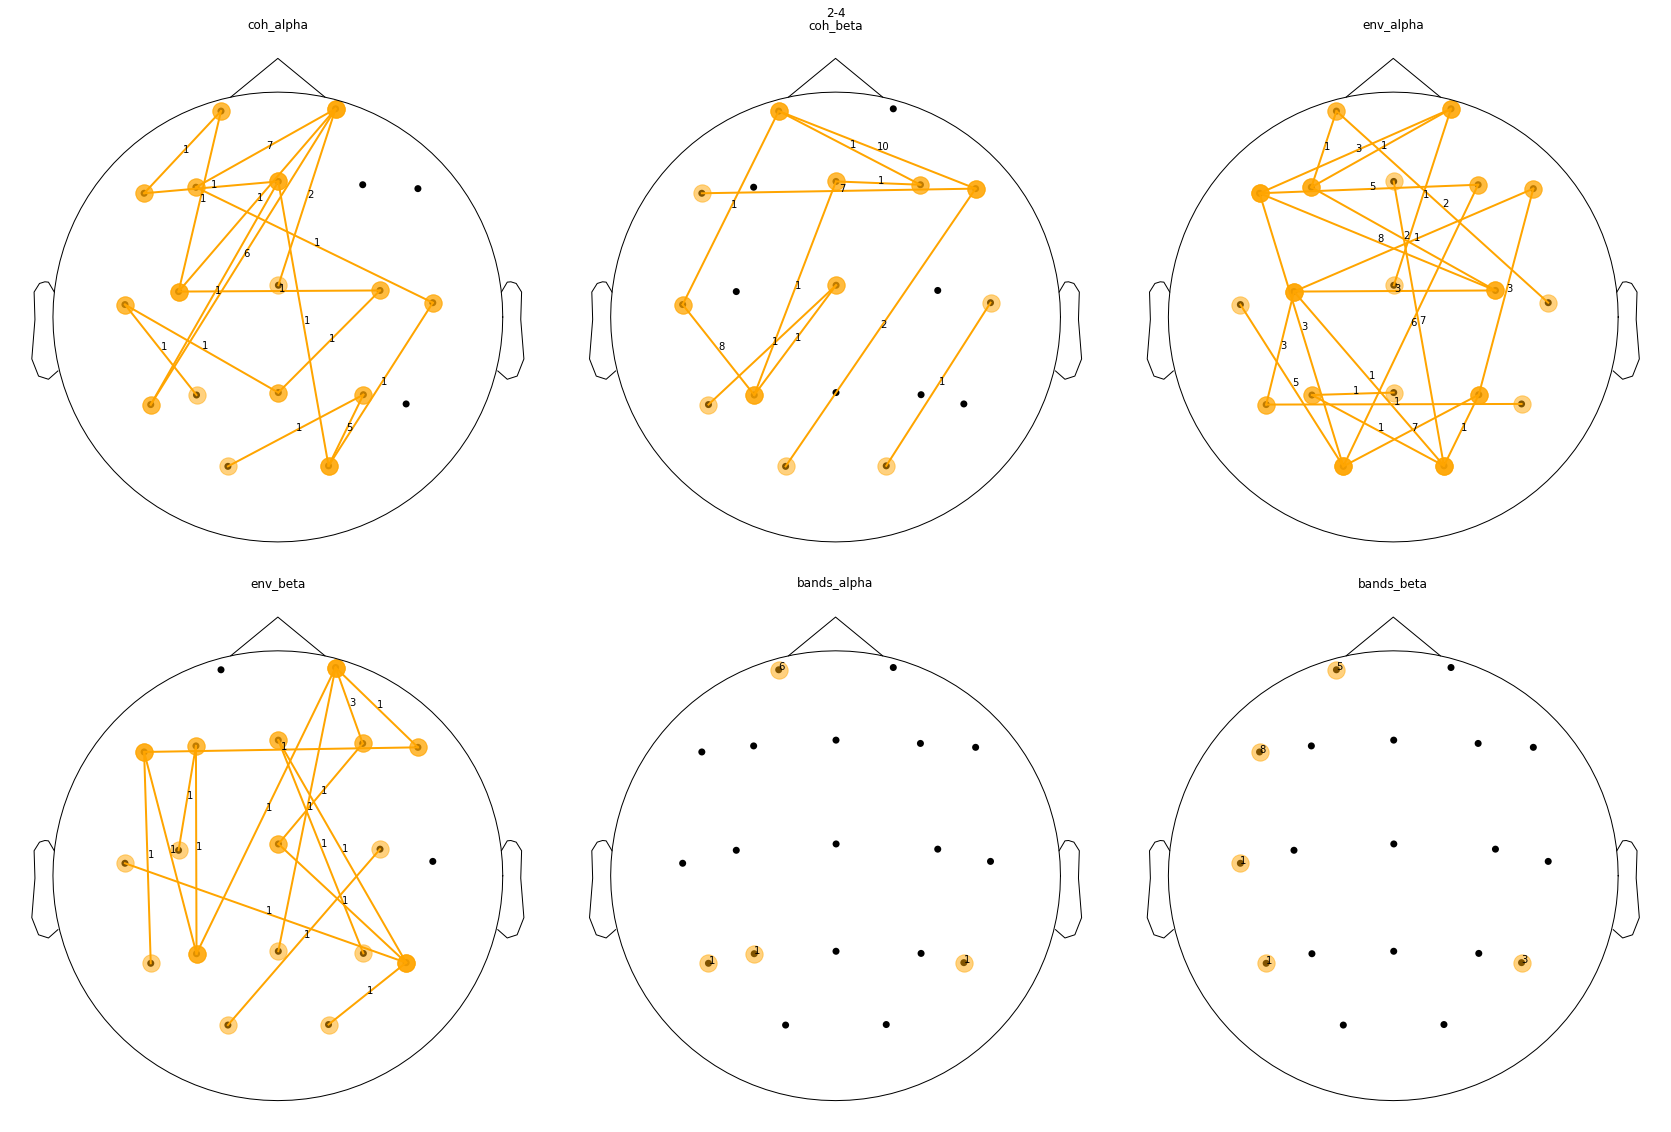

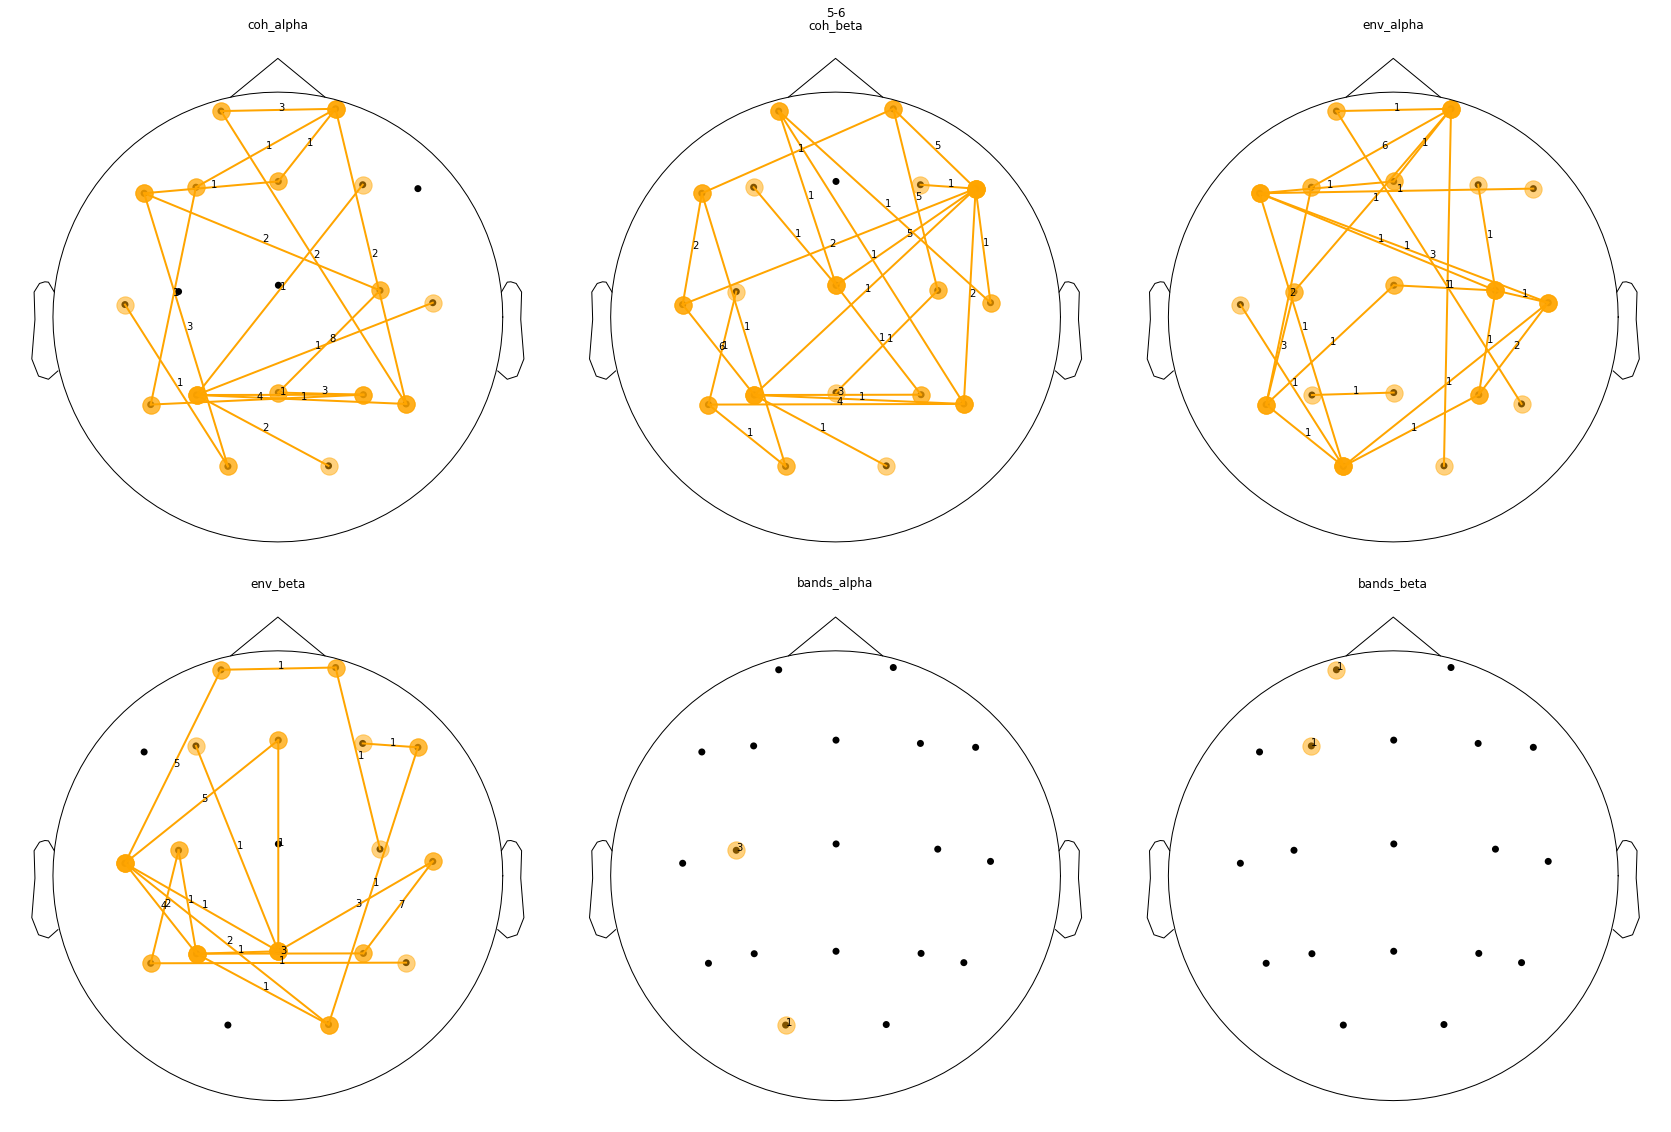

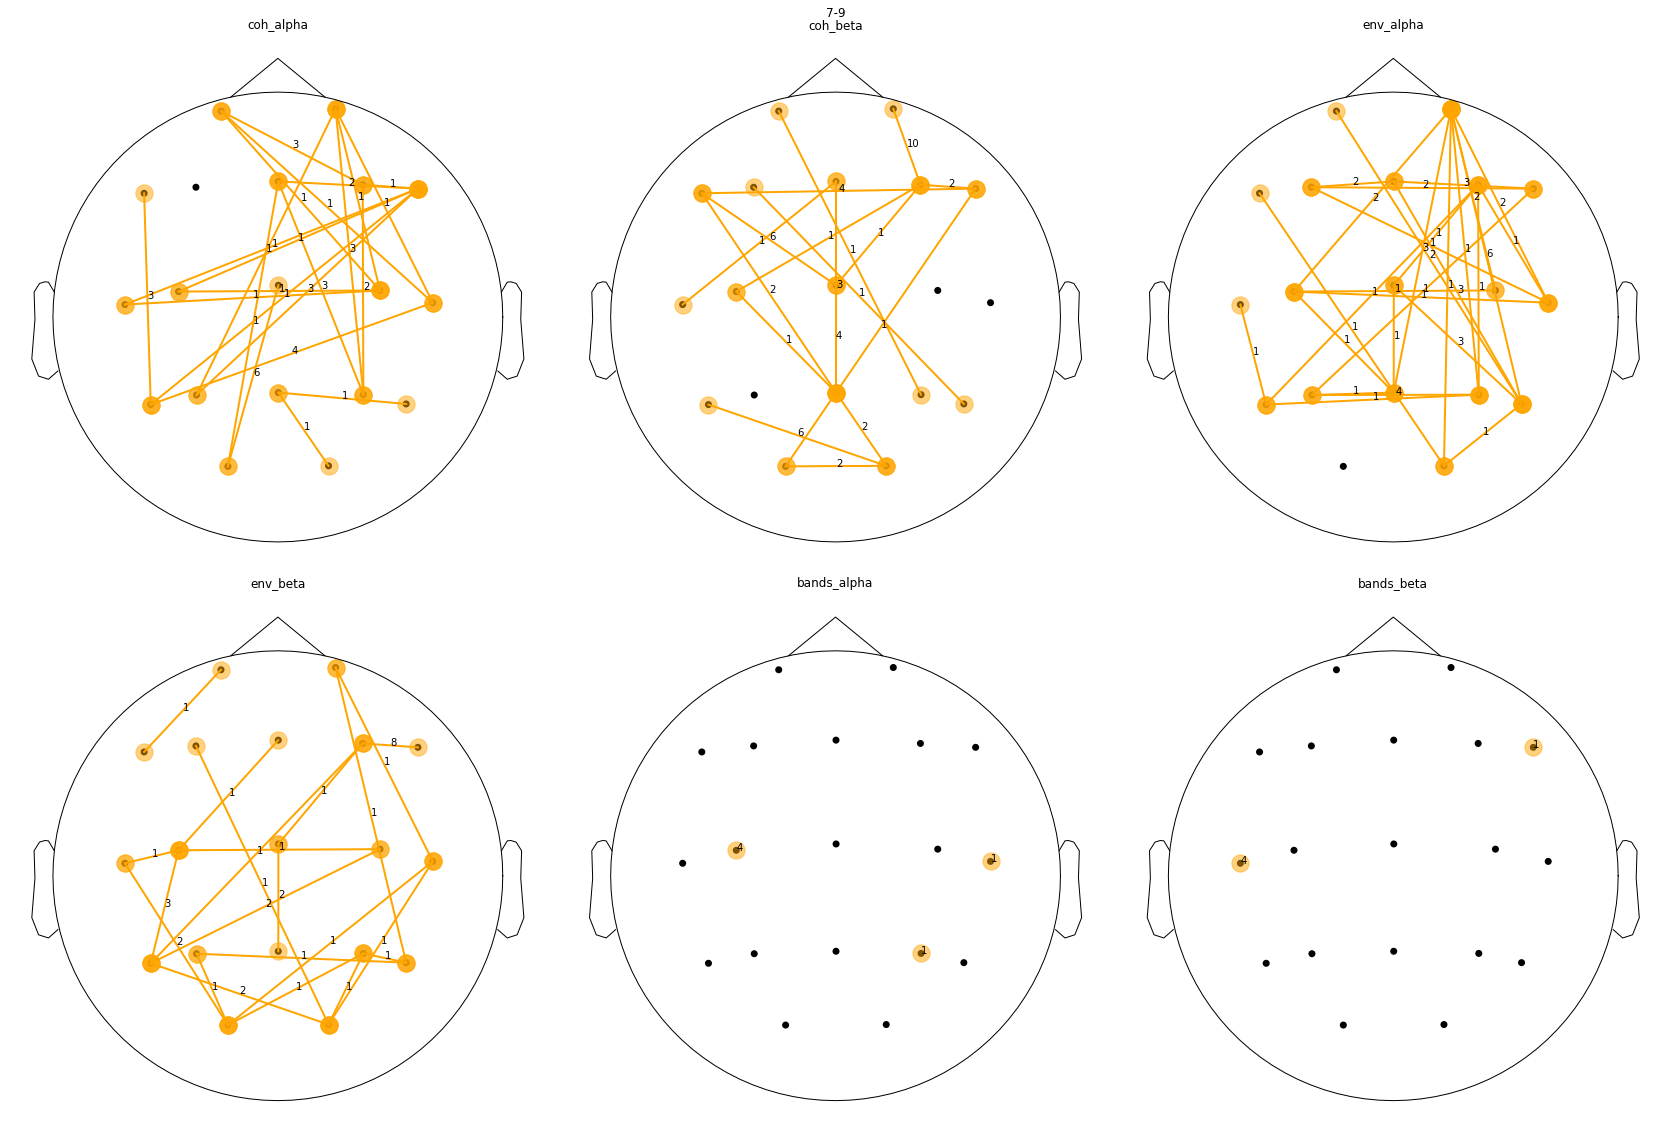

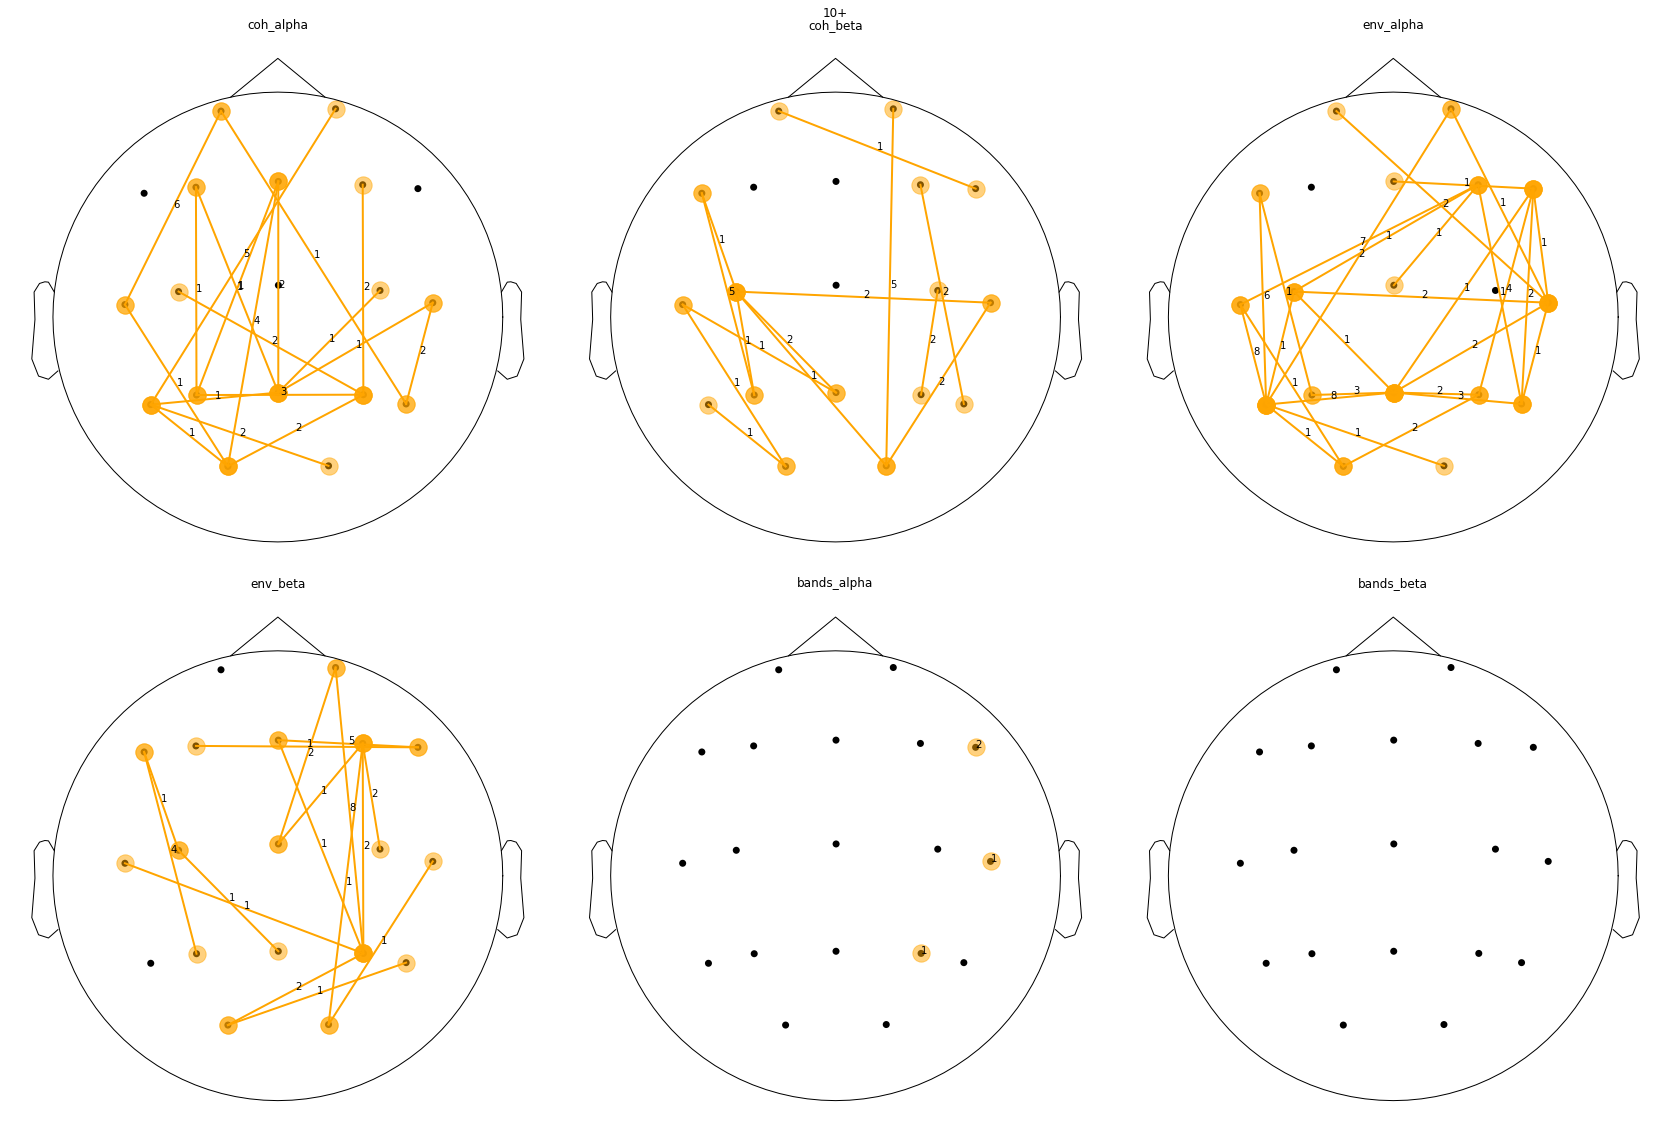

In [27]:
for ag_name, c in counts.items():
    fig, axes = plt.subplots(2, 3, figsize=[24, 16])
    plt.subplots_adjust(wspace=0)
    plot_featues_agg(c, flatten(axes))
    fig.suptitle(ag_name)
    plt.tight_layout()
    plt.savefig(f'../images/asd/({ag_name})_combined.jpg')

### ROC curves

In [23]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_pred, title=None, auc=None, save_path=None):
    fpr, tpr, _ = roc_curve(y_true, y_pred)

    if auc is None:
        auc = roc_auc_score(y_true, y_pred)

    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (average area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if title is not None:
        plt.title(title)
    plt.legend(loc="lower right")
    if save_path:
        plt.savefig(save_path, transparent=True, dpi=150)

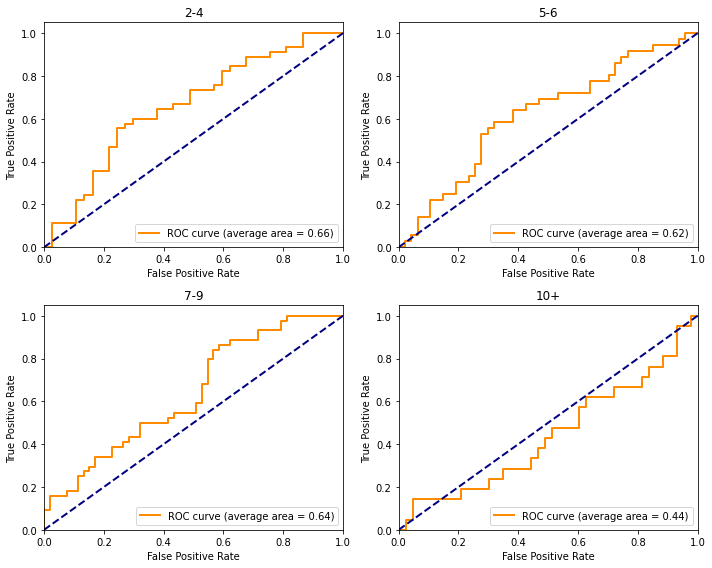

In [25]:
plt.figure(figsize=(10, 8))
for i, ag_name in enumerate(age_groups, 1):
    plt.subplot(2, 2, i)
    plot_roc_curve(scores[ag_name].y_true, scores[ag_name].y_pred, title=ag_name)
    
plt.tight_layout()
plt.savefig(f'../images/asd/roc-curves.jpg')

## Train-test validation

In [7]:
selected_features = {}
scores = {}

for ag_name, ag in age_groups.items():
    df = data[data['age'].isin(ag)].copy().reset_index(False)
    method = validation.TrainTestValidator(df, features, model, p_bar=0)
    selected_features[ag_name], scores[ag_name] = method.get_features()
    print(f"Age group {ag_name}:\n\tn_subjects = {len(df)}\n\t{scores[ag_name].roc_auc = }\n\t{scores[ag_name].acc = }")

Age group 2-4:
	n_subjects = 82
	scores[ag_name].roc_auc = 0.6607142857142857
	scores[ag_name].acc = 0.6
Age group 5-6:
	n_subjects = 83
	scores[ag_name].roc_auc = 0.6785714285714286
	scores[ag_name].acc = 0.5333333333333333
Age group 7-9:
	n_subjects = 97
	scores[ag_name].roc_auc = 0.8392857142857143
	scores[ag_name].acc = 0.7333333333333333
Age group 10+:
	n_subjects = 64
	scores[ag_name].roc_auc = 0.66
	scores[ag_name].acc = 0.6666666666666666


### Selected features

In [8]:
selected_features['2-4']

['env_alpha_C3_C4',
 'env_alpha_P3_Pz',
 'env_beta_Fp2_F4',
 'env_alpha_T3_C4',
 'coh_beta_Fp1_F8',
 'coh_alpha_Fp2_F3',
 'bands_beta_F7',
 'coh_alpha_P4_O2',
 'bands_beta_Fp1',
 'coh_beta_T3_P3',
 'coh_alpha_Fp2_T5',
 'env_alpha_T3_O1',
 'env_alpha_F7_F3',
 'coh_alpha_Cz_P3',
 'env_beta_F7_F8',
 'env_beta_C3_P4',
 'env_alpha_Fp1_T4',
 'env_beta_Fp1_Cz',
 'coh_alpha_F8_Cz',
 'env_beta_T4_P4']

In [9]:
selected_features['5-6']

['coh_beta_T3_P3',
 'env_beta_T3_P3',
 'env_alpha_Fp1_T6',
 'coh_alpha_T5_P4',
 'coh_alpha_T4_P4',
 'env_beta_T3_C3',
 'coh_beta_Fp2_F8',
 'coh_beta_F8_Cz',
 'env_alpha_Fp2_F3',
 'coh_beta_Fp2_T3',
 'env_alpha_C3_T5',
 'env_alpha_F7_F4',
 'env_alpha_Fp2_T5',
 'env_alpha_F3_O1',
 'coh_alpha_F7_F4']

In [10]:
selected_features['7-9']

['coh_alpha_F4_F8',
 'env_beta_F4_F8',
 'coh_beta_Fp2_F4',
 'coh_alpha_Cz_O1',
 'coh_beta_F7_F8',
 'env_alpha_Cz_T6',
 'coh_alpha_Fz_F8',
 'env_alpha_P3_P4',
 'env_alpha_Fp2_F4',
 'env_alpha_Fp2_T6',
 'env_alpha_F4_T4',
 'coh_alpha_Fp1_T6',
 'env_beta_P3_T6',
 'coh_alpha_Fz_P4',
 'coh_beta_T5_O2',
 'env_beta_T5_P3',
 'env_alpha_F3_T4',
 'coh_alpha_F8_T3',
 'env_beta_F3_T3',
 'coh_alpha_F3_T6']

In [11]:
selected_features['10+']

['env_alpha_T5_Pz',
 'env_alpha_F4_T3',
 'env_alpha_T5_O1',
 'env_alpha_F8_P4',
 'coh_alpha_Fz_O1',
 'env_alpha_T3_O1',
 'env_alpha_Fp2_T5',
 'env_alpha_F7_T5',
 'env_alpha_Fp2_T3',
 'env_beta_Fp2_P4',
 'env_beta_T4_O2',
 'env_alpha_F4_C3',
 'env_alpha_T4_T6']

### ROC cruves

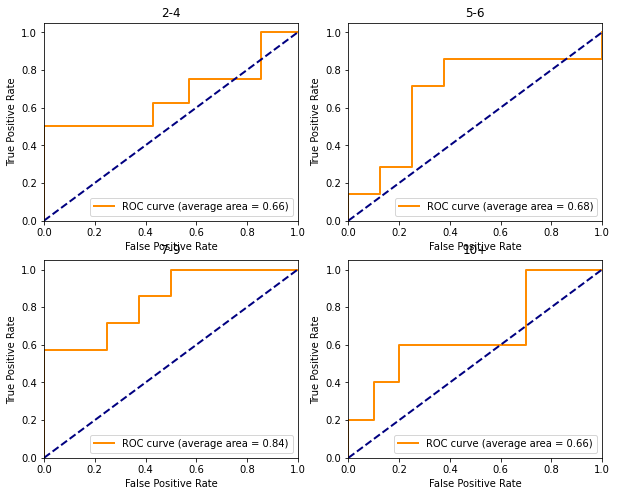

In [14]:
plt.figure(figsize=(10, 8))
for i, ag_name in enumerate(age_groups, 1):
    plt.subplot(2, 2, i)
    plot_roc_curve(scores[ag_name].y_true, scores[ag_name].y_pred, title=ag_name)